# MIDS Differential Privacy Assignment

Definition: We say that a mechanism $M$ is $\epsilon$-differential private if, for all databases $D$ and $D'$ that differ on exactly one element, and all measurable $S \subseteq Codomain(M) $,

$$ \mathbb{P}(M(D) \in S) \le exp(\epsilon)\mathbb{P}(M(D') \in S)$$

By symmetry, an equivalent way to represent this is as

$$ exp(-\epsilon) \le \frac{\mathbb{P}(M(D) \in S)}{\mathbb{P}(M(D') \in S)} \le exp(\epsilon)$$

## Exercise 1

The following questions are conceptual checks. Be as specific as possible with your justifications.

(1) Why is the definition of differential privacy multiplicative as opposed to additive?

(2) How does differential privacy address the fact that an individual's risk of identification increases every time the data is queried? How does this relate to the concept of privacy budget?

(3) Could differential privacy have neutralized the Personal Project Genome attack?

https://www.forbes.com/sites/adamtanner/2013/04/25/harvard-professor-re-identifies-anonymous-volunteers-in-dna-study/#6992f47e92c9

(4) Suppose you know in advance that $K$ queries will be asked of a differentially private mechanism. What can you do to ensure a total privacy loss of $\epsilon$?

(5) What happens if you don't know how many queries will be asked of your differentially private mechanism. There could be 17 queries, or 3901 queries, or an unlimited amount. What can you do to ensure a total privacy loss of $\epsilon$ over all queries?


#### Solution
(1) Multiplication protects against mechanisms where a curator randomly selects one person and publish their result. If a database has $n$ people in it, this does indeed protect the privacy of all folks not selected, but it really sucks for the person whose information is released. Differentially privacy protects against this type of "but only one person would be harmed" argument. 

Formally, let $S$ = {Person $i$'s info gets published}. We can find a pair of neighboring databases $D$ and $D'$, such that $i$ is in $D$ but not $D'$. This is because there are neighboring databases where person $i$ is in one table (call it $D$), but not in the other (call it $D'$). So, $ \mathbb{P}(M(D) \in S) =1$ and $ \mathbb{P}(M(D') \in S) =0$ for any measurable set $S$.

Thus, DP invalidates arguments of the form "there is low risk for an individual to be harmed in this mechanism."

Note that this definition also invalidates any truthful response to the query "is person $i$ in the data?" This follows by the exact same argument above - we can find two neighboring datasets in which person $i$ is in it (call it $D$) and another where person $i$ isn't included (call it $D'$). Then, $ \mathbb{P}(M(D) \in S) =1$ and $ \mathbb{P}(M(D') \in S) =0$, where $S \subseteq \{0,1\}$.

(2) This is done by the composition theorems. The fact that we add $\epsilon$'s for each query means there is additional privacy leaked with each additional query. This relates to notion of a privacy budget, as it stops a would-be attacker from imposing un-due risk via repeated execution of a differentially private query system.

(3) Yes. Differential privacy protects against linkage attacks, which is what this attack was. More spefically, this is guaranteed by the post-processing theorem.

(4) For each query, use $\frac{\epsilon}{K}$ instead of epsilon. That way, after $K$ queries, the total privacy loss would be $\epsilon$ but the composition theorem. Once this data has been queried $K$ times, retire the dataset.

(5) Since there are possibly an infinite number of queries, we have to be a bit sneakier. For query $i$ we can use $\frac{\epsilon}{2^{i}}$ instead of $\epsilon$. This way, the total privacy loss over an infinite number of queries is $\epsilon$ by a routine application of the geometric series.

## Exercise 2

Suppose we have access to a database of individuals in a county, containing information on whether or not an individual has commited a felony or not. Call this data $X$, such that $X[i] = 1$ if person $i$ has a criminal record. 

You receive a request from a client for information regarding how many people in the county have criminal records. Being the privacy-conscience data curator you are, know the potential privacy implications of returning this true value. You explain to the client that you can give them a differentially private answer, but they are on the fence about the inaccuracies introduced via random noise insertion.

### Part A
Explain to the client that there is a tradeoff between privacy and utility using simulaiton using the following array and candidate epsilon values.

In [0]:
## This portion creates a dataset with 1200 folks without a criminal record, and 800 folks with one
import numpy as np
np.random.seed(0)

x = np.asarray([0 for x in range(1200)] + [1 for x in range(800)])
eps_list_1 = [0.010, 0.015, 0.020, 0.025, 0.030]

#### Solution

In [0]:
def laplace_counter(x,value, eps):
    return np.sum(x == value) + np.random.laplace(loc = 0, scale = 1.0/eps, size = 1)[0]

In [0]:
def lap_count_sim(x, value, eps_list, sim_size):
    true_count = np.sum(x == value)
    eps_repo = dict((eps, 0) for eps in eps_list)
    for eps in eps_list:
        catcher = []
        for i in range(sim_size):
            catcher.append(laplace_counter(x, value, eps))
        catcher = np.asarray(catcher)
        dev_val =  np.mean(100.0 * np.abs(true_count - catcher) / true_count)
        eps_repo[eps] = dev_val
    return eps_repo

In [3]:
results = lap_count_sim(x = x, value = 1, eps_list = eps_list_1, sim_size = 1000)

import matplotlib.pyplot as plt
%matplotlib inline

x_vals = np.sort(results.keys())
y_vals = [results[i] for i in x_vals]
plt.bar(range(len(results)), y_vals, align='center')
plt.xticks(range(len(results)), x_vals)
plt.show()

NameError: ignored

### Part B
If we want to choose an $\epsilon$ that is within $10$% of the truth value on average, which $\epsilon$ should we choose? Explain your choice.

#### Solution
Choose $\epsilon = 0.015$. This will give us the best privacy from the epsilon list, while being within the 10% requirement.

### Part C

Suppose we go ahead and use the $\epsilon$ from Part B. We'd like to be able to attach a confidence value that this specific $\epsilon$ will be within w% of the truth. Desgin an algorithm to do this. What is the confidence we have for being within 10% of the truth?

#### Solution

This is equivalent to asking "if I did this process many times, what fraction of trials would be within $w$% of the true value?" Hence, we can easily simulate this.

In [0]:
def lap_count1_times_within_range(x, value, eps, sim_size, tolerance):
    true_count = np.sum(x == value)
    catcher = []
    for i in range(sim_size):
        catcher.append(laplace_counter(x, value, eps))
    catcher = np.asarray(catcher)
    return 100.0 * np.sum(np.abs(catcher - true_count) < tolerance * true_count) / sim_size

In [0]:
print lap_count1_times_within_range(x = x, value = 1, eps = 0.015, sim_size = 10000, tolerance = 0.10)

69.5


## Exercise 3

Suppose now we are interested in the proportion of individuals with a criminal record, as opposed to a count. Furthermore, imagine that we want to build a general query system that takes in (1) the percent error an individual is willing to accept and (2) the confidence level they want for the result. 

Simulations are cool and all, but they are rather computationally expensive. Using elementary probability, create an algorithm that takes in (1) and (2) as inputs, and computes a differentially private estimate of the mean. Show your work for the derivation of the algorithm, and run a few test cases to verify that it indeed works.

#### Solution

Note that the proportion of a boolean set is equivalent to the average. As such, we can use Laplace noise on the mean estimator.

Suppose the output of an $\epsilon$-differntially private mechanism is 

$$\hat\theta = \theta + \nu$$

where $\theta$ is the true answer of the requested query and $\nu$~$F$ is random noise from some distribution with CDF $F$.

If we require that the output of the mechanism be within $100w$% of the true value $\theta$ with $100p$% confidence, then we are seek $\epsilon$ such that

$$ \mathbb{P}(|\hat\theta - \theta| < w\theta) = p $$

The LHS trivially reduces to $F(w\theta) - F(-w\theta)$. Thus, we seek $\epsilon$ such that

$$ F(w\theta) - F(-w\theta)= p $$

This statement is true regardless of the noise distribution and the query in question.

Now, we apply this result to the special case of average queries where $\nu$ ~ $Laplace(\frac{n}{\epsilon})$, where $n$ is the number of individuals in the dataset.

The LHS is equivalent to the CDF of an Exponential distribution with rate parameter $\epsilon$. This yeilds

$$ 1-\exp(\frac{-\epsilon w\theta}{n}) = p$$

Solving this for $\epsilon$ produces

$$ \epsilon = \frac{n\log(\frac{1}{1-p})}{w\theta} $$

In [0]:
def dp_estimate(x, value, w, p):
    theta = np.mean(x)
    eps = -1.0 * len(x) * np.log(1-p) / (w* theta)
    return theta + np.random.laplace(loc = 0, scale = 1.0/eps, size = 1)[0]

print "dp_estimate with confidence inputs loaded successfully"

dp_estimate with confidence inputs loaded successfully


In [0]:
print dp_estimate(x, 1, 0.10, 0.7)

0.399984791221


## Exercise 4

Suppose we have a dataset of political party affiliation. 

In [0]:
x = np.asarray(["REPUB" for x in range(1000)] + ["DEMOC" for x in range(1100)] + ["INDEP" for x in range(400)])

We want to release a differentially private estimate of the mode with $\epsilon$ = 0.1 

(A) Write a function to do this. 

(B) Explain what differential privacy does to the underlying distribution of this categorical data.

(C) Is "INDEP" more likely to occur with a large $\epsilon$ or a small $\epsilon$?

#### Solution

In [0]:
from collections import Counter
import numpy as np
import operator

def report_noisy_max(x, eps):
    counts = Counter(x)
    for key in counts:
        counts[key] += np.random.laplace(loc = 0, scale = 1.0/eps, size = 1)[0]
    dp_max_key = max(counts.iteritems(), key=operator.itemgetter(1))[0]
    return (dp_max_key, counts[dp_max_key])

Differential privacy "fuzzes" the true height of the barplot for each category. To see how this works, let's first plot the true barplot.

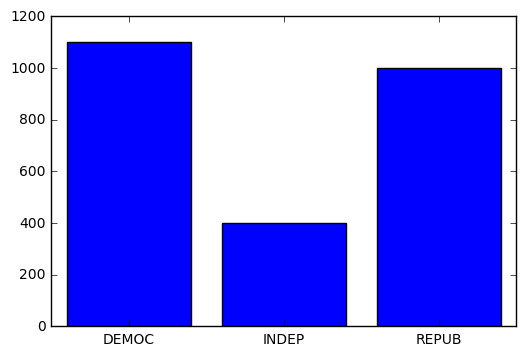

In [0]:
results = Counter(x)

x_vals = np.sort(results.keys())
y_vals = [results[i] for i in x_vals]
plt.bar(range(len(results)), y_vals, align='center')
plt.xticks(range(len(results)), x_vals)
plt.show()

With the Report Noisy Max algorithm, we randomly add Laplace noise to each categories count. This "fuzzes" the true height of the barplot, thereby adding uncertainty prior to the computaiton of the max function.

Lastly, we know that large $\epsilon$'s prefer accuracy over privacy. As such, a lot of randomness needs to be applied for "INDEP" to actually be the output of the mechanism. Thus, we need a smaller $\epsilon$.

## EXTRA - DIFFERENTIAL PRIVACY WITH THE STOCHASTIC GRADIENT DESCENT

Note to Nathan and Will - this is a really cool application of differntial privacy - however, this seems way too involved. I've included it for completeness, but feel free to scrap it

Using the MNIST dataset, build two classifiers to predict whether a given image is a 2 or a 3: one using logistic regression with stochastic gradient descent, and another using differentially private logistic regression with stochastic gradient descent.

In [0]:
## Note -- may need to do 
## pip install mnist
## first
import mnist

print "Success"

Success


In [0]:
import os
import pandas as pd
import numpy as np

print "Success"

Success


In [0]:
from sklearn.datasets import fetch_mldata
mnist_dataset = fetch_mldata('MNIST original')
Y_2 = mnist_dataset['data'][np.where(mnist_dataset['target'] == 2.)[0]]
Y_3 = mnist_dataset['data'][np.where(mnist_dataset['target'] == 3.)[0]]
print 'number of twos:', Y_2.shape[0]
print 'number of threes:', Y_3.shape[0]


number of twos: 6990
number of threes: 7141


In [0]:
Y_2.shape

(6990, 784)

In [0]:
data = np.vstack([Y_2, Y_3])
labels = np.asarray([0 for j in range(Y_2.shape[0])] + [1 for j in range(Y_3.shape[0])])

print data.shape
print labels.shape

(14131, 784)
(14131,)


In [0]:
## Standard Logistic Regression 

## Logistic regression prediction function
def log_reg_predict(coeff, x):
    return 1.0 / (1.0 + np.exp(-1.0 * np.dot(coeff, np.asarray([1] + x))))

## Stochastic Gradient Descent for Logistic Regression
def log_reg_coef_sgd(features, labels, l_rate, num_epochs):
    coef = [0.0 for j in range(features.shape[1])]
    ## RANDOMLY SHUFFLE THE DATASET
    for epoch in range(num_epochs):
        accumulated_cost = 0
        for i in range(features.shape[0]):
            row = features[i]
            yhat = log_reg_predict(coef, row)
            error = row[-1] - yhat
            accumulated_cost += error**2
            coef[0] += l_rate * error * yhat * (1.0 - yhat)
            for j in range(len(row)-1):
                coef[j + 1] += l_rate * error * yhat * (1.0 - yhat) * row[j]
    return coef

## Differentially Private Stochastic Gradient Descent for Logistic Regression
## http://cseweb.ucsd.edu/~kamalika/pubs/scs13.pdf
## This paper shows the global sensitity for batch gradient descent of size b is 2.0 * learning_rate / b
## Thus, for stochastic gradient descent, b = 1 => sensitivity of 2.0 * learning_rate
def DP_log_reg_coef_sgd(features, labels, l_rate, num_epochs, eps):
    coef = [0.0 for j in range(features.shape[1])]
    ## RANDOMLY SHUFFLE THE DATASET
    for epoch in range(num_epochs):
        accumulated_cost = 0
        for i in range(features.shape[0]):
            row = features[i]
            yhat = log_reg_predict(coef, row)
            error = row[-1] - yhat
            accumulated_cost += error**2
            coef[0] += (l_rate * error * yhat * (1.0 - yhat) + 
                        np.random.laplace(loc = 0, scale = (2.0 * l_rate)/eps, size = 1)[0])
            for j in range(len(row)-1):
                coef[j + 1] += (l_rate * error * yhat * (1.0 - yhat) * row[j] + 
                                np.random.laplace(loc = 0, scale = (2.0 * l_rate)/eps, size = 1)[0])
    return coef

##
print "Utility functions loaded"

Utility functions loaded


In [0]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(9467, 784)
(9467,)
(4664, 784)
(4664,)


In [0]:
coeff = log_reg_coef_sgd(X_train, y_train, 1, 1)

In [0]:
def log_reg_scorer(X_train, y_train, X_test, y_test, l_rate, num_epochs, threshold):
    ## Learn the coefficients
    coeff = log_reg_coef_sgd(X_train, y_train, l_rate, num_epochs)
    ## Predict on the test set
    catcher = []
    for i in range(len(y_test)):
        predicted_val = 1*(log_reg_predict(coeff, X_test[i]) >= threshold)
        catcher.append(1*(y_test[i] == predicted_val))
    ## Return the accuracy
    return 100.0 * np.sum(catcher) / len(catcher)

print "Scorer function loaded"

Scorer function loaded


In [0]:
def DP_log_reg_scorer(X_train, y_train, X_test, y_test, l_rate, num_epochs, threshold, epsilon):
    ## Learn the coefficients
    coeff = DP_log_reg_coef_sgd(X_train, y_train, l_rate, num_epochs, epsilon)
    ## Predict on the test set
    catcher = []
    for i in range(len(y_test)):
        predicted_val = 1*(log_reg_predict(coeff, X_test[i]) >= threshold)
        catcher.append(1*(y_test[i] == predicted_val))
    ## Return the accuracy
    return 100.0 * np.sum(catcher) / len(catcher)

print "Scorer function loaded"

Scorer function loaded


In [0]:
print log_reg_scorer(X_train, y_train, X_test, y_test, 1, 1, 0.5)

>epoch=0, error=0.250
>epoch=1, error=0.000
>epoch=2, error=0.000
>epoch=3, error=0.000
>epoch=4, error=0.000
49.9785591767


In [0]:
sim_size = 10
score_catcher = []
for k in range(sim_size):
    print "simulation " + str(k+1)  
    score_catcher.append(DP_log_reg_scorer(X_train, y_train, X_test, y_test, 1, 1, 0.5, 0.1))
    
print np.mean(score_catcher)

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
51.5544596913


Note that the accuracy is on par with the non differenitally private version. 

In addition, if we plot the learning curves for these two methods, we should see the training and validation curves closer to on another in the differentially private version. This implies that differential privacy protects against overfitting.